In [1]:
% matplotlib inline 

from neurosynth.base.dataset import Dataset
from neurosynth.analysis import decode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['svg.fonttype'] = 'none'

/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Applications/miniconda3/envs/topography/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def getOrder(d, thr):
    dh = []
    for i in range(0,len(d)):
        di = d[i]
        dh.append(np.average(np.array(xrange(0,len(d[i]))) + 1, weights=di))
    heatmapOrder = np.argsort(dh)
    return heatmapOrder

In [3]:
# Import neurosynth database:
pickled_dataset = '../topography/metaanalysis/neurosynth/dataset.pkl' #'gradient_data/neurosynth/dataset.pkl'
dataset = Dataset.load(pickled_dataset)

In [5]:
%%bash

# Create masks for metaanalysis

# to run for all components, replace line below with:
# for i in `seq 0 9`; do
for i in `seq 0 25`; do

    let ind="${i} + 1" 

    wb_command -cifti-merge gradient_data/embedded/ciftis/hcp.embed.${i}.dscalar.nii \
        -cifti gradient_data/embedded/ciftis/hcp.embed.dscalar.nii -column ${ind}
    
    wb_command -cifti-separate gradient_data/embedded/ciftis/hcp.embed.${i}.dscalar.nii COLUMN \
        -metric CORTEX_LEFT gradient_data/embedded/ciftis/hcp.embed.${i}.L.metric \
        -metric CORTEX_RIGHT gradient_data/embedded/ciftis/hcp.embed.${i}.R.metric \
        -volume-all gradient_data/embedded/ciftis/hcp.embed.${i}.volume.nii
    
    wb_command -metric-to-volume-mapping gradient_data/embedded/ciftis/hcp.embed.${i}.L.metric \
        gradient_data/templates/S900.L.midthickness_MSMAll.32k_fs_LR.surf.gii \
        gradient_data/templates/MNI152_T1_2mm_brain.nii.gz gradient_data/embedded/volumes/volume.${i}.L.nii \
        -ribbon-constrained gradient_data/templates/S900.L.white_MSMAll.32k_fs_LR.surf.gii \
        gradient_data/templates/S900.L.pial_MSMAll.32k_fs_LR.surf.gii 
        
    wb_command -metric-to-volume-mapping gradient_data/embedded/ciftis/hcp.embed.${i}.R.metric \
        gradient_data/templates/S900.R.midthickness_MSMAll.32k_fs_LR.surf.gii \
        gradient_data/templates/MNI152_T1_2mm_brain.nii.gz gradient_data/embedded/volumes/volume.${i}.R.nii \
        -ribbon-constrained gradient_data/templates/S900.R.white_MSMAll.32k_fs_LR.surf.gii \
        gradient_data/templates/S900.R.pial_MSMAll.32k_fs_LR.surf.gii         

    # combine:
    fslmaths gradient_data/embedded/volumes/volume.${i}.L.nii \
        -add gradient_data/embedded/volumes/volume.${i}.R.nii \
        -add gradient_data/embedded/ciftis/hcp.embed.${i}.volume.nii \
        gradient_data/embedded/volumes/volume.orig.${i}.nii
        
        
    fslmaths gradient_data/embedded/volumes/volume.${i}.L.nii \
        -add gradient_data/embedded/volumes/volume.${i}.R.nii \
        -add gradient_data/embedded/ciftis/hcp.embed.${i}.volume.nii \
        -abs -bin gradient_data/embedded/volumes/mask.${i}.nii
        
    p=`fslstats gradient_data/embedded/volumes/volume.orig.${i}.nii -R | awk '{print $1;}'`  
    fslmaths gradient_data/embedded/volumes/mask.${i}.nii -mul ${p#-} gradient_data/embedded/volumes/mask.${i}.nii
    fslmaths gradient_data/embedded/volumes/volume.orig.${i}.nii.gz \
        -add gradient_data/embedded/volumes/mask.${i}.nii \
        gradient_data/embedded/volumes/volume.${i}.nii.gz

    # extract masks:
    mkdir gradient_data/embedded/volumes/emb_masks_${i}
    for j in `seq 0 5 95`; do
        let k="${j} + 5"
        fslmaths gradient_data/embedded/volumes/volume.${i}.nii \
            -thr `fslstats gradient_data/embedded/volumes/volume.${i}.nii -P ${j}` \
            -uthr `fslstats gradient_data/embedded/volumes/volume.${i}.nii -P ${k}` \
            -bin gradient_data/embedded/volumes/emb_masks_${i}/volume_$(printf %02d $j)_$(printf %02d $k).nii

    done
    
done

# Copy masks from Gradient_0 to masks directory
cp gradient_data/embedded/volumes/emb_masks_0/volume* gradient_data/masks/
rm -f gradient_data/embedded/volumes/vol*L.nii
rm -f gradient_data/embedded/volumes/vol*R.nii
rm -f gradient_data/embedded/volumes/mask*.nii.gz
rm -f gradient_data/embedded/ciftis/hcp.embed.*.L.metric
rm -f gradient_data/embedded/ciftis/hcp.embed.*.R.metric

mkdir: gradient_data/embedded/volumes/emb_masks_0: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_1: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_2: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_3: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_4: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_5: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_6: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_7: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_8: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_9: File exists
mkdir: gradient_data/embedded/volumes/emb_masks_10: File exists


In [7]:
# Analysis with 24 terms:
features = pd.read_csv('gradient_data/neurosynth/v3-topics-50.txt', sep='\t', index_col=0)
topics_to_keep = [ 1, 4,  6, 14, 
                  18, 19, 23, 25, 
                  20, 21, 27, 29,
                  30, 31, 33, 35, 
                  36, 38, 37, 41, 
                  44, 45, 48, 49]
labels = ['face/affective processing', ' verbal semantics', 'cued attention', 'working memory', 
          'autobiographical memory', 'reading', 'inhibition', 'motor', 
          'visual perception', 'numerical cognition', 'reward-based decision making', 'visual attention', 
          'multisensory processing', 'visuospatial','eye movements', 'action',
          'auditory processing', 'pain', 'language', 'declarative memory', 
          'visual semantics', 'emotion', 'cognitive control', 'social cognition']
features = features.iloc[:, topics_to_keep]
features.columns = labels
dataset.add_features(features, append=False)

# removed_as_noise = [0,5,9,12,17,40] # from 30 terms that were above threshold
# labels_noise = ['resting-state', 'dementia', 'development', 'misc', 'task timing', 'lateralization']

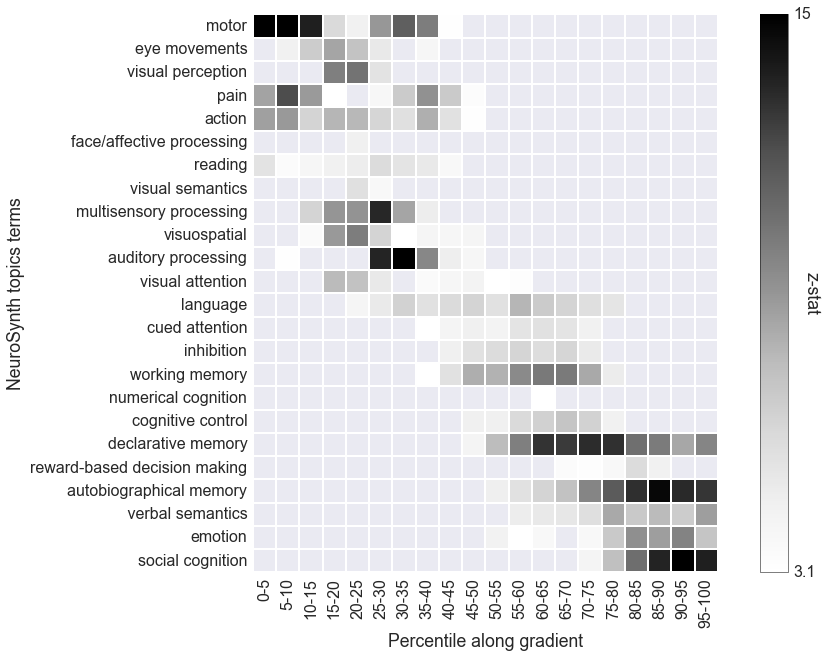

In [22]:
# Gradient 1

decoder = decode.Decoder(dataset, method='roi')

# Set threshold:
thr = 3.1
vmin = 0
vmax = 15

tot = 5
data = decoder.decode([str('gradient_data/masks/volume_%02d_%02d.nii.gz' % (i * tot, (i * tot) + tot)) 
                       for i in xrange(0,100/tot)])
df = []
df = data.copy()
newnames = []
[newnames.append(('%s-%s' % (str(i * tot), str((i*tot) + tot)))) for i in xrange(0,len(df.columns))]
df.columns = newnames
df[df<thr] = 0 
heatmapOrder = getOrder(np.array(df), thr)

sns.set(context="paper", font="sans-serif", font_scale=2)
f, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(15, 10), sharey=True)
plotData = df.reindex(df.index[heatmapOrder])
cax = sns.heatmap(plotData, linewidths=1, square=True, cmap='Greys', robust=False, 
            ax=ax1, vmin=thr, vmax=vmax, mask=plotData == 0)
sns.axlabel('Percentile along gradient', 'NeuroSynth topics terms')
cbar = cax.collections[0].colorbar
cbar.set_label('z-stat', rotation=270)
cbar.set_ticks(ticks=[thr,vmax])
cbar.set_ticklabels(ticklabels=[thr,vmax])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.5)

plt.draw()
f.savefig('gradient_data/figures/fig.neurosynth.svg', format='svg')